# AI Text Detection Project

# Introduction

The goal of this project is to create a machine learning model capable of distinguishing between AI-generated and human-written text. With the rapid advancements in natural language processing (NLP) and AI content generation tools like GPT, there is a growing need for tools that can identify AI-generated content. 

### Objectives
1. Preprocess the text data to clean and prepare it for model training.
2. Generate meaningful embeddings using state-of-the-art models like BERT.
3. Train a robust neural network model for classification.
4. Evaluate the model's performance using metrics like accuracy, precision, recall, and F1-score.
5. Demonstrate predictions on unseen text samples.

### Tools and Methodologies
- **Python Libraries**: TensorFlow, PyTorch, scikit-learn, Pandas, Matplotlib.
- **Embedding Techniques**: BERT, Word2Vec.
- **Model Architecture**: Fully connected neural network (MLP).
- **Evaluation Metrics**: Accuracy, confusion matrix, classification report.

# Step 1:
### Data Preparation

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import save_npz
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

In [4]:

file_path = "R:/text_detection_project/datasets/Training_Essay_Data.csv"
data = pd.read_csv(file_path)


print("Dataset Preview:")
print(data.head())

print("\nColumn Names:")
print(data.columns)

print(f"\nDataset contains {data.shape[0]} rows and {data.shape[1]} columns.")

print("\nMissing Values in Each Column:")
print(data.isnull().sum())


Dataset Preview:
                                                text  generated
0  Car-free cities have become a subject of incre...          1
1  Car Free Cities  Car-free cities, a concept ga...          1
2    A Sustainable Urban Future  Car-free cities ...          1
3    Pioneering Sustainable Urban Living  In an e...          1
4    The Path to Sustainable Urban Living  In an ...          1

Column Names:
Index(['text', 'generated'], dtype='object')

Dataset contains 29145 rows and 2 columns.

Missing Values in Each Column:
text         0
generated    0
dtype: int64


In [5]:
print("Null Values in Dataset:")
print(data.isnull().sum())

data = data.dropna()

print("\nAfter Handling Missing Data:")
print(data.isnull().sum())

Null Values in Dataset:
text         0
generated    0
dtype: int64

After Handling Missing Data:
text         0
generated    0
dtype: int64


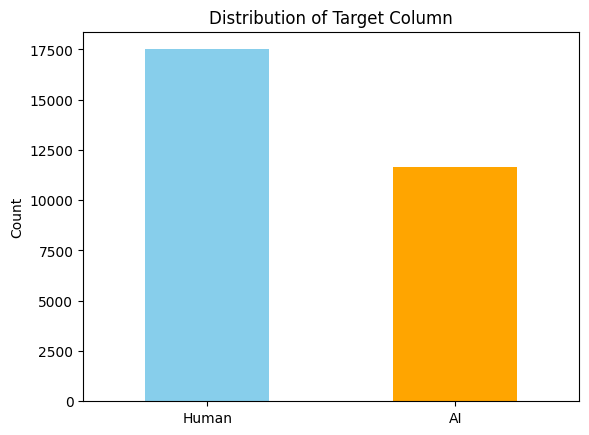

In [6]:
data['generated'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Distribution of Target Column")
plt.xticks([0, 1], ['Human', 'AI'], rotation=0)
plt.ylabel("Count")
plt.show()

# •	Text Cleaning:

In [7]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = text.strip()
    return text
data['cleaned_text'] = data['text'].apply(clean_text)
data.head()

,text,generated,cleaned_text
0,Car-free cities have become a subject of incre...,1,carfree cities have become a subject of increa...
1,"Car Free Cities Car-free cities, a concept ga...",1,car free cities carfree cities a concept gain...
2,A Sustainable Urban Future Car-free cities ...,1,a sustainable urban future carfree cities are...
3,Pioneering Sustainable Urban Living In an e...,1,pioneering sustainable urban living in an era...
4,The Path to Sustainable Urban Living In an ...,1,the path to sustainable urban living in an ag...


# •	Tokenization and Lemmatization:

In [8]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

def tokenize_text(text):
    return word_tokenize(text)

data['tokens'] = data['cleaned_text'].apply(tokenize_text)
data['lemmatized'] = data['tokens'].apply(lemmatize_tokens)

print(data[['tokens', 'lemmatized']].head())

                                              tokens  \
0  [carfree, cities, have, become, a, subject, of...   
1  [car, free, cities, carfree, cities, a, concep...   
2  [a, sustainable, urban, future, carfree, citie...   
3  [pioneering, sustainable, urban, living, in, a...   
4  [the, path, to, sustainable, urban, living, in...   

                                          lemmatized  
0  [carfree, city, have, become, a, subject, of, ...  
1  [car, free, city, carfree, city, a, concept, g...  
2  [a, sustainable, urban, future, carfree, city,...  
3  [pioneering, sustainable, urban, living, in, a...  
4  [the, path, to, sustainable, urban, living, in...  


In [9]:
# Saveing the intermediate dataset we can use if we need or somethign happnes in between
lemmatized_dataset_path = "R:/text_detection_project/datasets/lemmatized_dataset.csv"
data.to_csv(lemmatized_dataset_path, index=False)
print(f"Intermediate lemmatized dataset saved at: {lemmatized_dataset_path}")


Intermediate lemmatized dataset saved at: R:/text_detection_project/datasets/lemmatized_dataset.csv


# Feature Extraction

# •	BoW (Bag of Words):

In [10]:

vectorizer_bow = CountVectorizer(max_features=5000)

bow_features = vectorizer_bow.fit_transform(data['lemmatized'].apply(lambda x: ' '.join(x)))

bow_df = pd.DataFrame(bow_features.toarray(), columns=vectorizer_bow.get_feature_names_out())

from scipy.sparse import save_npz
sparse_bow_path = "R:/text_detection_project/datasets/bow_features.npz"
save_npz(sparse_bow_path, bow_features)
print(f"BoW sparse matrix saved at: {sparse_bow_path}")


print("Sample feature names:", vectorizer_bow.get_feature_names_out()[:10])
print("BoW Matrix Shape:", bow_features.shape)

BoW sparse matrix saved at: R:/text_detection_project/datasets/bow_features.npz
Sample feature names: ['ability' 'able' 'abolish' 'abolished' 'abolishing' 'about' 'above'
 'abroad' 'absence' 'absent']
BoW Matrix Shape: (29145, 5000)


# •	TF-IDF (Term Frequency-Inverse Document Frequency):

In [11]:
vectorizer_tfidf = TfidfVectorizer(max_features=5000)  

tfidf_features = vectorizer_tfidf.fit_transform(data['lemmatized'].apply(lambda x: ' '.join(x)))

tfidf_path = "R:/text_detection_project/datasets/tfidf_features.npz"
save_npz(tfidf_path, tfidf_features)
print(f"TF-IDF sparse matrix saved at: {tfidf_path}")


print("Sample feature names:", vectorizer_tfidf.get_feature_names_out()[:10])  # Display the first 10 features
print("TF-IDF Matrix Shape:", tfidf_features.shape)

TF-IDF sparse matrix saved at: R:/text_detection_project/datasets/tfidf_features.npz
Sample feature names: ['ability' 'able' 'abolish' 'abolished' 'abolishing' 'about' 'above'
 'abroad' 'absence' 'absent']
TF-IDF Matrix Shape: (29145, 5000)


# Word2Vec Embedding

In [12]:
from gensim.models import Word2Vec

sentences = data['lemmatized'].tolist()

word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

word2vec_path = "R:/text_detection_project/models/word2vec.model"
word2vec_model.save(word2vec_path)
print(f"Word2Vec model saved at: {word2vec_path}")


sample_word = "technology"  #just to check ....
if sample_word in word2vec_model.wv:
    word_vector = word2vec_model.wv[sample_word]
    print(f"Vector for '{sample_word}':", word_vector)
else:
    print(f"Word '{sample_word}' not found in Word2Vec vocabulary.")


Word2Vec model saved at: R:/text_detection_project/models/word2vec.model
Vector for 'technology': [-0.9213162   1.2578586  -0.94081867  2.1561832   1.4359027   2.3896177
  0.1883686   0.21833037  1.4607708  -1.8496993  -3.6278799   1.4923185
  1.7839651  -2.0344129   4.2579007   0.40493655 -3.640586    2.7175157
 -1.2509613  -0.96599853 -1.4035475   0.76586944 -0.96636575  2.2310352
 -1.7920154  -0.993429    3.391217    0.16427708  2.5316126  -1.2292655
 -1.740985    0.01703235 -2.3078783   3.1275535  -1.4692757   2.7091832
 -3.5837598   3.7493927   1.6461785  -0.2964345  -2.2153957  -1.3397535
  1.5384461   1.7134668   0.35383603  1.4504931   0.14381513 -0.63872164
  1.2256517   1.1964086   0.98339164  0.59597075  1.3249786   0.30374262
  0.889731   -0.7473351   4.459096    1.7112619  -3.3755462  -3.6393187
  1.3860856  -1.513555   -1.5619922  -3.8107448   2.1372423  -0.04111558
  2.1181216  -3.3664389   4.1813116   1.2295815   0.22608647 -3.0271819
 -0.8781463  -0.47355908  0.0512579

# •	BERT Embeddings:

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

In [14]:
# i am loading a pre trained bert model which i did earlier..
bert_embeddings_path = "R:/text_detection_project/datasets/bert_embeddings_combined.npy"
bert_embeddings = np.load(bert_embeddings_path)

print(f"BERT embeddings loaded from: {bert_embeddings_path}")
print(f"BERT Embeddings Shape: {bert_embeddings.shape}")


BERT embeddings loaded from: R:/text_detection_project/datasets/bert_embeddings_combined.npy
BERT Embeddings Shape: (32256, 768)


In [15]:
# Ensure the target labels match the embeddings
data = data[:bert_embeddings.shape[0]]  # Trim the dataset to match embeddings if necessary

# Update BERT embeddings to align with the dataset size
bert_embeddings = bert_embeddings[:len(data)]

# Confirm the updated shapes
print(f"Updated Dataset Shape: {data.shape}")
print(f"Updated BERT Embeddings Shape: {bert_embeddings.shape}")


Updated Dataset Shape: (29145, 5)
Updated BERT Embeddings Shape: (29145, 768)


# Splitting the Data for Training and Testing

In [16]:
from sklearn.model_selection import train_test_split


y = data['generated'].values

X_train, X_test, y_train, y_test = train_test_split(bert_embeddings, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")


Training data shape: (23316, 768)
Testing data shape: (5829, 768)
Training labels shape: (23316,)
Testing labels shape: (5829,)


# Training the Neural Network

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(512, activation='relu', input_shape=(768,)),  # Input layer + first hidden layer
    Dropout(0.3),                                       # Dropout for regularization
    Dense(256, activation='relu'),                      # Second hidden layer
    Dropout(0.3),                                       # Dropout for regularization
    Dense(1, activation='sigmoid')                      # Output layer (binary classification)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


Epoch 1/20
583/583 [==============================] - 8s 12ms/step - loss: 0.5110 - accuracy: 0.7182 - val_loss: 0.4740 - val_accuracy: 0.7391
Epoch 2/20
583/583 [==============================] - 5s 9ms/step - loss: 0.4678 - accuracy: 0.7434 - val_loss: 0.4538 - val_accuracy: 0.7603
Epoch 3/20
583/583 [==============================] - 5s 8ms/step - loss: 0.4582 - accuracy: 0.7525 - val_loss: 0.4490 - val_accuracy: 0.7611
Epoch 4/20
583/583 [==============================] - 5s 9ms/step - loss: 0.4503 - accuracy: 0.7576 - val_loss: 0.4452 - val_accuracy: 0.7650
Epoch 5/20
583/583 [==============================] - 5s 8ms/step - loss: 0.4454 - accuracy: 0.7617 - val_loss: 0.4422 - val_accuracy: 0.7695
Epoch 6/20
583/583 [==============================] - 5s 8ms/step - loss: 0.4402 - accuracy: 0.7628 - val_loss: 0.4473 - val_accuracy: 0.7611
Epoch 7/20
583/583 [==============================] - 5s 8ms/step - loss: 0.4375 - accuracy: 0.7637 - val_loss: 0.4577 - val_accuracy: 0.7530
Epoch

#  Evaluating the Model

183/183 [==============================] - 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.88      0.81      3539
           1       0.75      0.56      0.64      2290

    accuracy                           0.76      5829
   macro avg       0.75      0.72      0.73      5829
weighted avg       0.76      0.76      0.75      5829



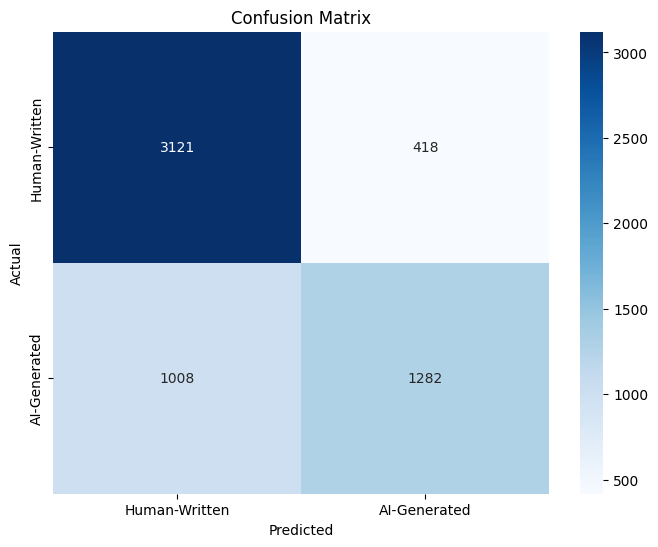

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Human-Written", "AI-Generated"], yticklabels=["Human-Written", "AI-Generated"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [19]:
# Saving the trained model
model_path = "R:/text_detection_project/models/tuned_final_nn_model_v1.h5"
model.save(model_path)
print(f"Model saved at: {model_path}")


Model saved at: R:/text_detection_project/models/tuned_final_nn_model_v1.h5


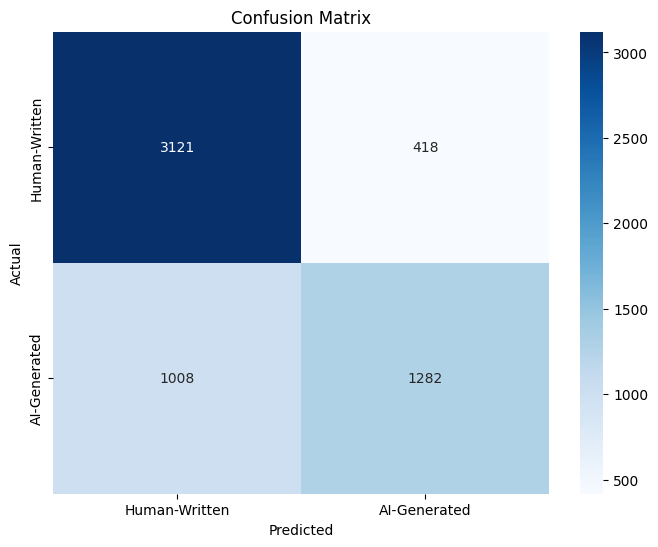

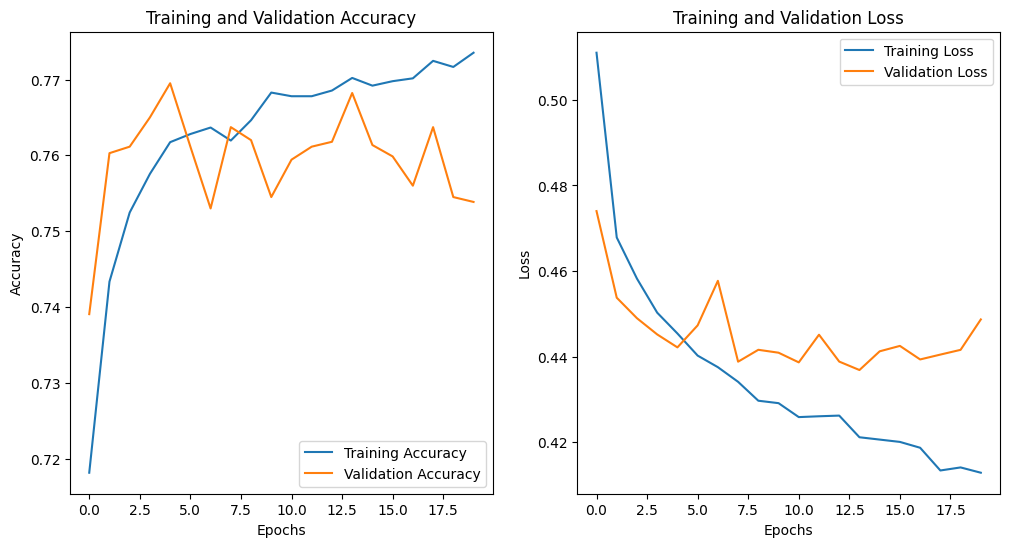

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate Confusion Matrix Plot
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Human-Written", "AI-Generated"], yticklabels=["Human-Written", "AI-Generated"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Generate Training History Plots
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# SVM Model

In [22]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import joblib

In [23]:

X_train, X_test, y_train, y_test = train_test_split(
    bert_embeddings, y, test_size=0.2, random_state=42
)

# Initialize the SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42)

print("Training SVM Model...")
for _ in tqdm(range(1), desc="Training Progress"):
    svm_model.fit(X_train, y_train)

print("\nSVM Model Training Completed!")

print("\nMaking Predictions with SVM...")
y_pred_svm = []
for i in tqdm(range(len(X_test)), desc="Prediction Progress"):
    y_pred_svm.append(svm_model.predict([X_test[i]]))

y_pred_svm = np.array(y_pred_svm).flatten() 


print("\nSVM Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_svm)
print(conf_matrix)

import joblib

svm_model_path = "R:/text_detection_project/models/svm_model.pkl"
joblib.dump(svm_model, svm_model_path)
print(f"\nSVM model saved at: {svm_model_path}")


Training SVM Model...


Training Progress: 100%|███████████████████████████████████████████████████████████████| 1/1 [44:02<00:00, 2642.49s/it]



SVM Model Training Completed!

Making Predictions with SVM...


Prediction Progress: 100%|████████████████████████████████████████████████████████| 5829/5829 [00:33<00:00, 171.79it/s]



SVM Model Evaluation:
Accuracy: 0.7596500257334019

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      3539
           1       0.72      0.63      0.67      2290

    accuracy                           0.76      5829
   macro avg       0.75      0.74      0.74      5829
weighted avg       0.76      0.76      0.76      5829


Confusion Matrix:
[[2984  555]
 [ 846 1444]]

SVM model saved at: R:/text_detection_project/models/svm_model.pkl


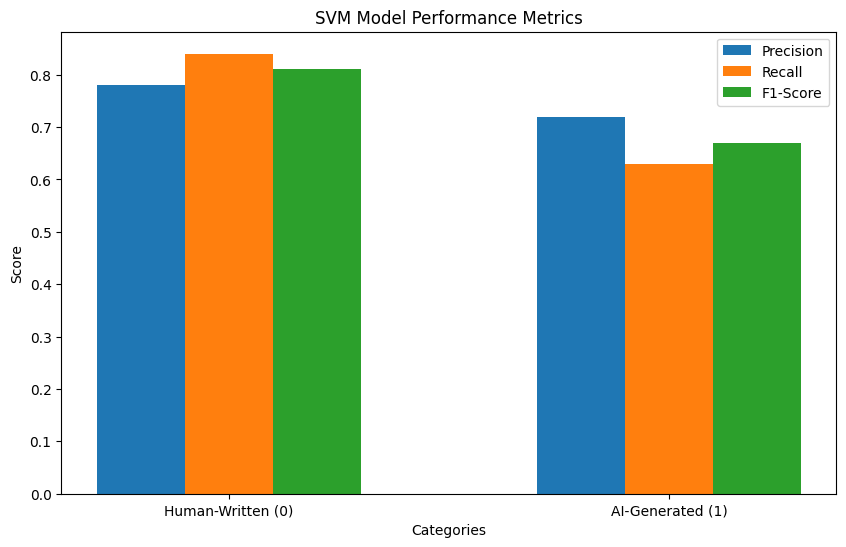

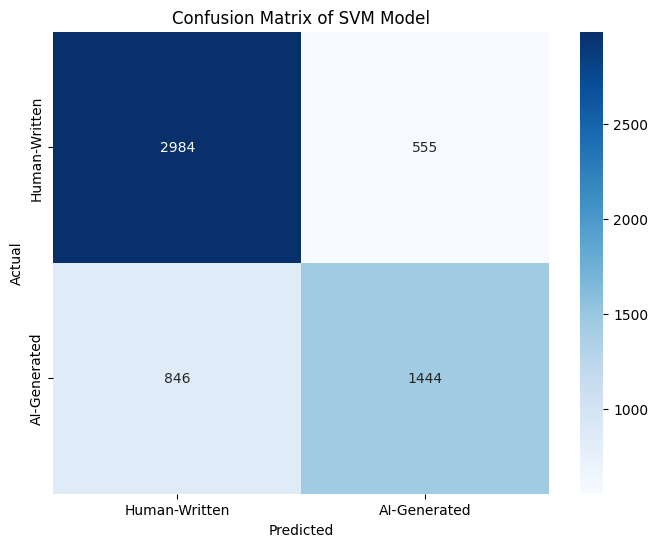

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Data for bar chart (Precision, Recall, F1-Score)
categories = ['Human-Written (0)', 'AI-Generated (1)']
precision = [0.78, 0.72]
recall = [0.84, 0.63]
f1_score = [0.81, 0.67]

x = range(len(categories)) 

plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision', align='center')
plt.bar([p + 0.2 for p in x], recall, width=0.2, label='Recall', align='center')
plt.bar([p + 0.4 for p in x], f1_score, width=0.2, label='F1-Score', align='center')

plt.xticks([p + 0.2 for p in x], categories)
plt.title('SVM Model Performance Metrics')
plt.xlabel('Categories')
plt.ylabel('Score')
plt.legend()
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Human-Written", "AI-Generated"],
            yticklabels=["Human-Written", "AI-Generated"])
plt.title("Confusion Matrix of SVM Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# testing the svm mode : test 1


In [30]:
from transformers import BertTokenizer, BertModel

svm_model_path = "R:/text_detection_project/models/svm_model.pkl"
svm_model = joblib.load(svm_model_path)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def preprocess_and_predict(sample_text, bert_model, svm_model):
    # Tokenize the input text and generate embeddings
    inputs = tokenizer(sample_text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embedding = outputs.last_hidden_state[:, 0, :].numpy()
    prediction = svm_model.predict(embedding)
    confidence = svm_model.decision_function(embedding)
    
    predicted_class = "AI-generated" if prediction[0] == 1 else "Human-written"
    print(f"Text: {sample_text}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence Score: {confidence[0]:.2f}")

sample_text = "The advancements in AI are astounding and changing the world rapidly."
preprocess_and_predict(sample_text, bert_model, svm_model)


Text: The advancements in AI are astounding and changing the world rapidly.
Predicted Class: AI-generated
Confidence Score: 1.67


# test 2

In [31]:
# List of sample texts for testing
sample_texts = [
    "The advancements in AI are astounding and changing the world rapidly.",
    "I had a fantastic weekend with friends, enjoying the countryside views.",
    "This essay discusses the implications of neural networks in modern technology.",
    "AI-generated content is often more formal and precise than human text.",
    "Human creativity is boundless, and no AI can truly replicate the emotions behind art.",
    "The future of AI and robotics is promising, with endless opportunities.",
    "I love spending time with family, sharing laughs and great food together."
]

def test_multiple_texts(sample_texts, bert_model, svm_model):
    for text in sample_texts:
        preprocess_and_predict(text, bert_model, svm_model)
        print("-" * 80)

test_multiple_texts(sample_texts, bert_model, svm_model)


Text: The advancements in AI are astounding and changing the world rapidly.
Predicted Class: AI-generated
Confidence Score: 1.67
--------------------------------------------------------------------------------
Text: I had a fantastic weekend with friends, enjoying the countryside views.
Predicted Class: Human-written
Confidence Score: -0.27
--------------------------------------------------------------------------------
Text: This essay discusses the implications of neural networks in modern technology.
Predicted Class: Human-written
Confidence Score: -1.23
--------------------------------------------------------------------------------
Text: AI-generated content is often more formal and precise than human text.
Predicted Class: AI-generated
Confidence Score: 0.25
--------------------------------------------------------------------------------
Text: Human creativity is boundless, and no AI can truly replicate the emotions behind art.
Predicted Class: AI-generated
Confidence Score: 0.88